### import dependencies

In [ ]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.legend_handler import HandlerBase
from matplotlib.transforms import TransformedBbox, Bbox
from matplotlib.offsetbox import TextArea, AnchoredOffsetbox
import sklearn.metrics as metrics
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler 

warnings.filterwarnings('ignore')

### read dataset

In [ ]:
dataset = pd.DataFrame(pd.read_excel("superstore.xlsx"))
dataset.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,CustomerID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


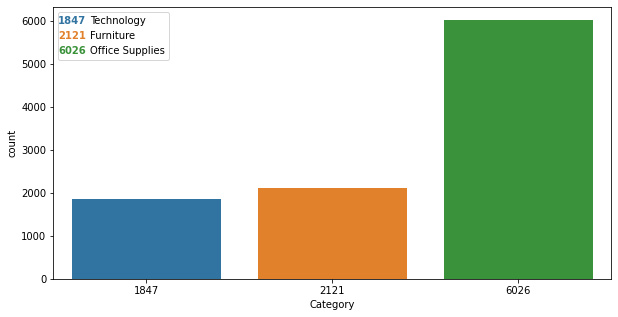

In [ ]:
class TextHandler(HandlerBase):
    def __init__(self, text, color="k"):
      self.text = text 
      self.color = color
      super(TextHandler, self).__init__()

    def create_artists(self, legend, orig_handle,xdescent, ydescent, width, height, fontsize,trans):
      bb = Bbox.from_bounds(xdescent,ydescent, width,height)
      tbb = TransformedBbox(bb, trans)
      textbox = TextArea(self.text, textprops={"weight":"bold","color":self.color})
      ab = AnchoredOffsetbox(loc=10,child=textbox, bbox_to_anchor=tbb, frameon=False)
      return [ab]

labels = ["Technology", "Furniture", "Office Supplies"]
plt.figure(figsize=(10, 5))
ax = sns.countplot(dataset["Category"], data=dataset["Category"].value_counts())
handles = [patches.Rectangle((0,0),1,1) for h in labels]
t = ax.get_xticklabels()
labeldic = dict(zip(labels, labels))
handlers = [TextHandler(h.get_text(),c.get_fc()) for h,c in zip(t,ax.patches)]
handlermap = dict(zip(labels, handlers))
ax.legend(labels, labels, handler_map=handlermap,) 

plt.show()

### Data cleaning and Preprocessing
**remove_alphabets()**: Removes alphabets from column values.

**convert_to_datetime()**: Convert string date to date object.




In [ ]:
def remove_alphabets(cols):
  for column in cols:
    X[column] = X[column].str.replace('\D+','').astype(int) 

def convert_to_datetime(cols):
  for column in cols:
    X[column] = pd.to_datetime(X[column]).values.astype(np.int)

# Extracting X(independent) and Y(dependent) values from dataset
X = dataset[[col for col in dataset.columns if col != "Sales"]]
Y = pd.DataFrame(dataset["Sales"].values)

# checking any missing values
print("Checking null values: ")
print(dataset.isnull().sum())

X = X.drop('Row ID',axis=1)
X = X.drop('Country',axis=1)
X = X.drop('Product Name', axis=1)
X = X.drop('Customer Name', axis=1)

remove_alphabets(['Order ID', 'CustomerID', 'Product ID'])
convert_to_datetime(['Ship Date', 'Order Date', 'Postal Code', 'Quantity'])

Checking null values: 
Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
CustomerID       0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64


### Feature Engineering

  * **LabelEncoder** maps catogorical values to integer between 1 to classes-1
  * **pd.get_dummies** creates additional features(columns) based on number of unique values the feature has.
  * **SimpleImputer** replaces any missing value by the mean of the feature/column.
  * **StandardScaler** standardizes the values to have 0 mean and deviation by 1.


In [ ]:
# label encoding of categorical values
def label_encoding(X, cols):
  le = LabelEncoder()
  for col in cols:
    X[col] = le.fit_transform(X[col])
  return X

numeric_features = ["Order ID",	"Order Date",	"Ship Date", "CustomerID", "Postal Code",	"Product ID", "Profit",	"Quantity",	"Discount"]
categorical_features = ["Ship Mode", "Segment", "Category", "Sub-Category", "Region", "State", "City"]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
      ('num', numeric_transformer, numeric_features),
    ])

preprocessor.fit_transform(X)
X = label_encoding(X, categorical_features)

# One hot Encoding
dummies = pd.get_dummies(X[categorical_features], columns=categorical_features, drop_first=False)
X = pd.concat([X, dummies], axis=1)

### Feature selection using heatmap and correlation matrix

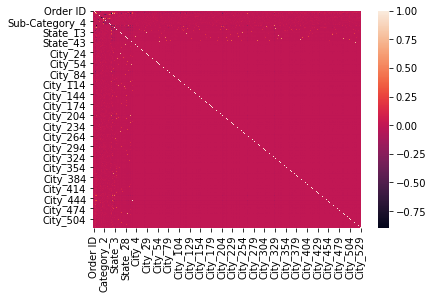

In [ ]:
corr = X.corr(method='pearson')
sns.heatmap(corr)

In [ ]:
# correlation matrix
cols = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
  for j in range(i+1, corr.shape[0]):
    if corr.iloc[i,j] >= 0.7:
      if cols[j]: cols[j] = False

selected = list()
for i in range(0,len(cols)):
  if(cols[i]==True):
    selected.append(X.columns[i])


print("Selected Features: ", selected)

# form X using selected columns/features
X = X[selected]

Selected Features:  ['Order ID', 'Ship Mode', 'CustomerID', 'Segment', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Quantity', 'Discount', 'Profit', 'Ship Mode_0', 'Ship Mode_1', 'Ship Mode_2', 'Segment_0', 'Segment_1', 'Category_0', 'Category_1', 'Sub-Category_0', 'Sub-Category_1', 'Sub-Category_2', 'Sub-Category_3', 'Sub-Category_4', 'Sub-Category_5', 'Sub-Category_6', 'Sub-Category_7', 'Sub-Category_8', 'Sub-Category_9', 'Sub-Category_10', 'Sub-Category_11', 'Sub-Category_12', 'Sub-Category_13', 'Sub-Category_14', 'Sub-Category_15', 'Sub-Category_16', 'Region_0', 'Region_1', 'Region_2', 'State_0', 'State_1', 'State_2', 'State_4', 'State_5', 'State_6', 'State_7', 'State_8', 'State_9', 'State_10', 'State_11', 'State_12', 'State_13', 'State_14', 'State_15', 'State_16', 'State_17', 'State_18', 'State_19', 'State_20', 'State_21', 'State_22', 'State_23', 'State_24', 'State_25', 'State_26', 'State_27', 'State_28', 'State_29', 'State_30', 'State_31', 

### Splitting dataset into training and testing sets
Splitting dataset into 70% train-set and 30% test-set.

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

### Training using RandomForestRegressor
Initializing a RandomForestRegressor.

Training on train set and its labels.

In [ ]:
rf = RandomForestRegressor()
rf.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

### Model accuracy and predictions  

In [ ]:
print("Model accuracy on Train data:", rf.score(X_train, Y_train)*100)
print("Model accuracy on Test data: ", rf.score(X_test, Y_test)*100)

preds = rf.predict(X_test)

Model accuracy on Train data: 95.33419380114493
Model accuracy on Test data:  82.30973334580335


Graph of predicted sales vs actual sales.

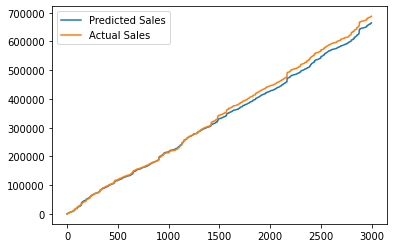

In [ ]:
preds = pd.DataFrame(np.array(preds).reshape(-1,1))

data_to_plot = pd.DataFrame(zip(preds.values, Y_test.values), columns=['Predicted Sales', 'Actual Sales'])
data_to_plot = data_to_plot.astype(float)

data_to_plot = data_to_plot.cumsum().plot()

### Model evaluations
Evaluation using RMSE and MAE.

**Note**

  Since the values in the dataset are scattered the MAE and RMSE values are large.
  
  In order for MAE and RMSE values to be between 0 and 1, the dataset values should be closer the regression line.  



In [ ]:
mae_test = metrics.mean_absolute_error(preds, Y_test)
mse_test = metrics.mean_squared_error(preds, Y_test)
rmse_test = np.sqrt(mse_test)

print("MAE score: ", mae_test)
print("RMSE score: ", rmse_test)

MAE score:  71.24385455485161
RMSE score:  255.96654737251404


# Forecasting using ARIMA
ARIMA is Autoregressive integrated moving average.

It is used in time series analysis to predict future points (**Sales**, in this case).

In [ ]:
# installing dependencies
!pip3 install pmdarima &> /dev/null

### import dependencies

In [ ]:
import statsmodels.api as sm
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

### Forcasting of furniture sales

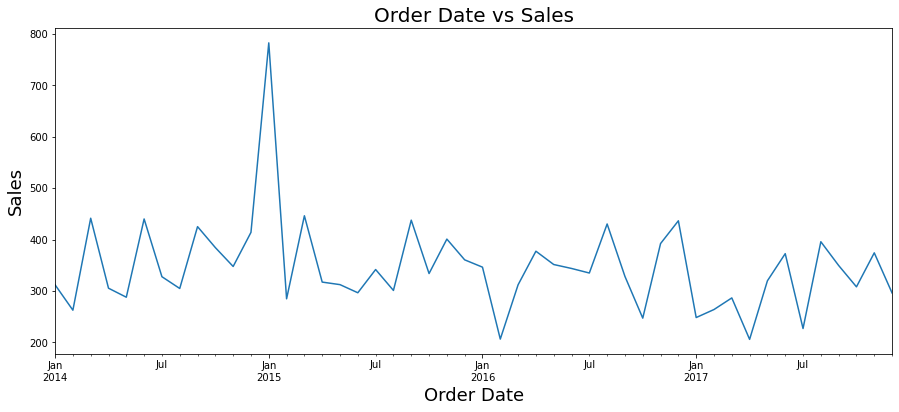

In [ ]:
# collecting only furniture data from dataset
furniture = dataset.loc[dataset['Category'] == 'Furniture']

# keep 'Order Date' and 'Sales'
furniture.drop([col for col in list(dataset.columns) if col != "Order Date" and  col != "Sales"], axis=1, inplace=True)

furniture = furniture.sort_values('Order Date')
furniture = furniture.set_index('Order Date')
furniture_y = furniture['Sales'].resample('MS').mean()

furniture_y.plot(figsize=(15,6))
plt.ylabel("Sales",fontsize=18)
plt.xlabel("Order Date",fontsize=18)
plt.title("Order Date vs Sales",fontsize=20)
plt.show()

ad_test() performs the **Augmented Dicky-Fuller** test. 

This test is performed to check whether the data is stationary or not.

Stationary time series data means the data does not depend upon time, whereas a Non-stationary time series data depends upon time.

In [ ]:
def ad_test(dataset):
  ad_test_result = adfuller(dataset, autolag='AIC')
  print("1. ADF: ", ad_test_result[0])
  print("2. P-Value: ", ad_test_result[1])
  print("3. No of Lags: ", ad_test_result[2])
  print("4. No of Obs used: ", ad_test_result[3])
  print("5. Critical Values: ")
  for key, val in ad_test_result[4].items():
    print("\t", key, ": ", val)

In [ ]:
ad_test(furniture_y)

1. ADF:  -6.962405221214862
2. P-Value:  9.093398510006677e-10
3. No of Lags:  0
4. No of Obs used:  47
5. Critical Values: 
	 1% :  -3.5778480370438146
	 5% :  -2.925338105429433
	 10% :  -2.6007735310095064


In [ ]:
stepfit = auto_arima(dataset["Sales"], trace=True, suppress_warnings=True)
stepfit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=156993.813, Time=2.85 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=156986.321, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=156987.836, Time=0.26 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=156987.882, Time=0.63 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=158258.982, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=156989.834, Time=1.38 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 5.439 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 9994
Model:                        SARIMAX   Log Likelihood              -78491.161
Date:                Thu, 29 Apr 2021   AIC                         156986.321
Time:                        17:01:14   BIC                         157000.741
Sample:                             0   HQIC                        156991.202
                               - 9994                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    229.8580      9.270     24.796      0.000     211.689     248.027
sigma2      3.884e+05    659.261    589.138      0.000    3.87e+05     3.9e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):          39057648.26
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                            12.97
Prob(H) (two-sided):                  0.11   Kurtosis:                       308.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### ARIMA model for FURNITURE

In [ ]:
arima_model_furniture = sm.tsa.statespace.SARIMAX(furniture_y,
                               order=(0,0,0),
                               seasonal_order= (1,1,0,12),
                               enforce_stationarity = False,
                               enforce_invertibility=False)

results = arima_model_furniture.fit()

                                SARIMAX Results                                 
Dep. Variable:                    Sales   No. Observations:                   48
Model:             SARIMAX(1, 1, 0, 12)   Log Likelihood                -145.723
Date:                  Thu, 29 Apr 2021   AIC                            295.446
Time:                          17:01:14   BIC                            297.803
Sample:                      01-01-2014   HQIC                           296.072
                           - 12-01-2017                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.3979      0.066     -6.039      0.000      -0.527      -0.269
sigma2        1.1e+04   2704.559      4.068      0.000    5699.984    1.63e+04
Ljung-Box (L1) (Q):                 

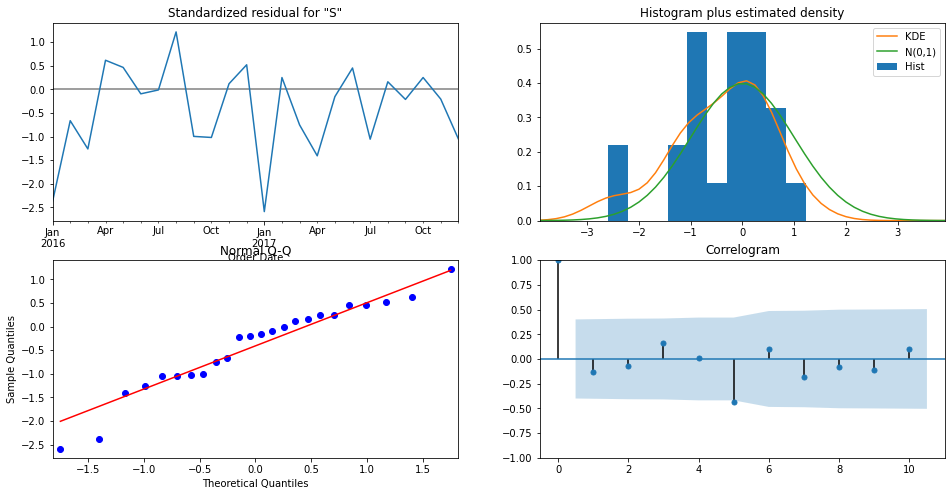

In [ ]:
print(results.summary())
results.plot_diagnostics(figsize=(16,8))
plt.show()

### Get forecast on Furniture sales.

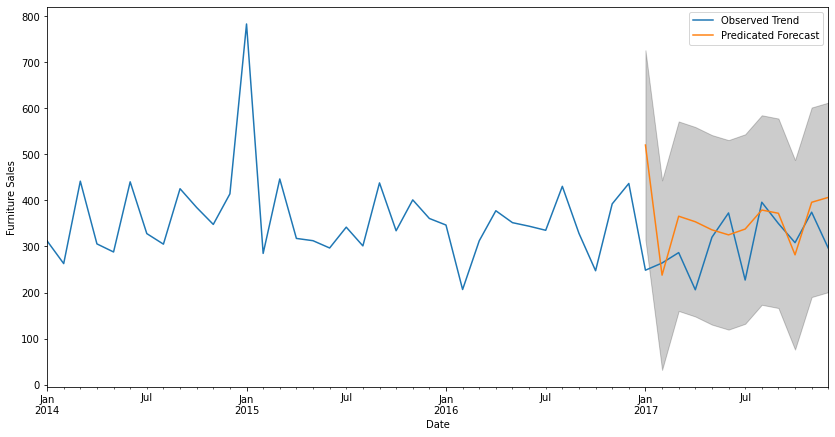

In [ ]:
pred = results.get_prediction(start = pd.to_datetime('2017-01-01'), dynamic = False)
pred_ci = pred.conf_int()

ax = furniture_y['2014':].plot(label= 'Observed Trend')

pred.predicted_mean.plot(ax = ax, label = 'Predicated Forecast',
                        alpha = 7, figsize= (14,7))

ax.fill_between(pred_ci.index,
               pred_ci.iloc[:,0],
               pred_ci.iloc[:,1],color = 'k', alpha= 0.2)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()

plt.show()

# Stacking



**Base Learners or Level 0 learners**
*   DecisionTreeRegressor
*   Support Vector

**Meta Learners or Level 1 learners**
*   Logistic Regression


### import dependencies

In [ ]:
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [ ]:
def stacking():
  level_0 = list()
  level_0.append(('desc', DecisionTreeRegressor()))
  level_0.append(('svm', SVR()))
  level_1 = LinearRegression()
  model = StackingRegressor(estimators=level_0, final_estimator=level_1, cv=5)
  return model

In [ ]:
stacking_model = stacking()
stacking_model.fit(X_train, Y_train)

StackingRegressor(cv=5,
                  estimators=[('desc',
                               DecisionTreeRegressor(ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=None,
                                                     max_features=None,
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     presort='deprecated',
                                                     random_state=None,
                                                 

In [ ]:
stacking_preds = stacking_model.predict(X_test)

### Stacking model accuracy

In [ ]:
print("Model accuracy on Train data:", stacking_model.score(X_train, Y_train)*100)
print("Model accuracy on Test data: ", stacking_model.score(X_test, Y_test)*100)

Model accuracy on Train data: 99.88647533179473
Model accuracy on Test data:  77.63800563981282


### Model evaluations after stacking

In [ ]:
stacking_mae_test = metrics.mean_absolute_error(stacking_preds, Y_test)
stacking_mse_test = metrics.mean_squared_error(stacking_preds, Y_test)
stacking_rmse_test = np.sqrt(mse_test)

print("MAE score: ", stacking_mae_test)
print("RMSE score: ", stacking_rmse_test)

MAE score:  88.27463146562171
RMSE score:  255.96654737251404


Graph of predicted sales after applying stacking vs Actual Sales.

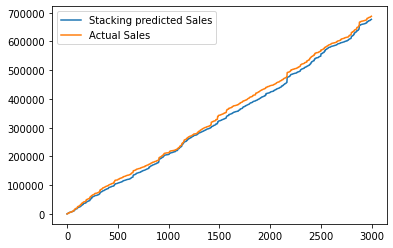

In [ ]:
stacking_preds = pd.DataFrame(np.array(stacking_preds).reshape(-1,1))

data_to_plot = pd.DataFrame(zip(stacking_preds.values, Y_test.values), columns=['Stacking predicted Sales', 'Actual Sales'])
data_to_plot = data_to_plot.astype(float)

data_to_plot = data_to_plot.cumsum().plot()

Graph of **Actual sales** vs **sales from stacking** vs **sales from RandomForrestRegressor**

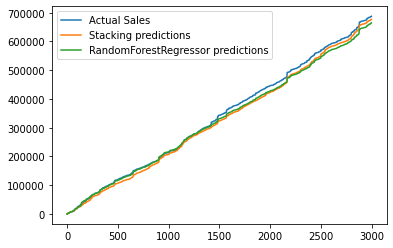

In [ ]:
all_preds = pd.DataFrame(zip(Y_test.values, stacking_preds.values, preds.values), 
                         columns=['Actual Sales', 'Stacking predictions', 'RandomForestRegressor predictions']).astype(float)
all_preds = all_preds.cumsum().plot()